# LSTM Notebook

This is a notebook to be used for implementing the LSTM model using PyTorch. Will be using the same data the RNN Notebook has already preprocessed.

In [1]:
# Importing libraries to work with
import re
import os
import nltk
import spacy
import torch
import shutil
import random
import numpy as np
import scipy as sci
import polars as pl
import pandas as pd
import gensim as gns
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# For the sake of Preprocessing
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Word Embedding
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

# Sklearn
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split

In [2]:
# Load w2v model
w2v_skipgram = Word2Vec.load("../wordembed/w2v_sg.model")

In [3]:
# Define hyper params for later use
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = 2
EPOCHS = 15
BATCH_SIZE = 100
LR = 0.001
MAX_SEQ_LEN = 40

In [4]:
# Load the data
loadable_data = pl.read_ndjson("../data/imdb_clean.json")

loadable_data.head()

review,sentiment
list[str],str
"[""one"", ""reviewer"", … ""side""]","""positive"""
"[""wonderful"", ""little"", … ""do""]","""positive"""
"[""think"", ""wonderful"", … ""friend""]","""positive"""
"[""basically"", ""there"", … ""ignore""]","""negative"""
"[""petter"", ""matteis"", … ""work""]","""positive"""


In [5]:
def class_to_num(sentiment):
    return 1 if sentiment == "positive" else 0

loadable_data = loadable_data.with_columns(
    pl.col("sentiment").map_elements(class_to_num, return_dtype = int)
)

In [6]:
def review_to_embedding(review, max_seq_len, embedding_dim):
    embeddings = [
        w2v_skipgram.wv[word] if word in w2v_skipgram.wv else np.zeros(embedding_dim)
        for word in review
    ]
    embeddings = embeddings[:max_seq_len]  # Truncate
    # Pad with zeros if shorter than max_seq_len
    if len(embeddings) < max_seq_len:
        embeddings += [np.zeros(embedding_dim)] * (max_seq_len - len(embeddings))
    return np.array(embeddings, dtype=np.float32)

In [7]:
loadable_data = loadable_data.with_columns(
    pl.col("review").map_elements(lambda x: review_to_embedding(x, MAX_SEQ_LEN, EMBEDDING_DIM), return_dtype = list[list[float]])
)

In [8]:
loadable_data.head()

review,sentiment
list[list[f64]],i64
"[[0.053646, 0.169129, … -0.117089], [0.059409, 0.257952, … -0.150777], … [0.237985, 0.285544, … 0.107752]]",1
"[[0.069264, 0.210273, … -0.045096], [-0.046261, 0.047188, … -0.098948], … [0.039598, -0.053692, … -0.114939]]",1
"[[0.07442, 0.106315, … -0.042415], [0.069264, 0.210273, … -0.045096], … [0.042387, 0.08614, … -0.150596]]",1
"[[-0.073931, 0.041117, … -0.132843], [-0.067784, -0.000722, … -0.014203], … [-0.013528, 0.08617, … -0.264038]]",0
"[[0.0, 0.0, … 0.0], [0.185396, 0.459882, … -0.617428], … [0.124108, 0.039394, … -0.057854]]",1


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    loadable_data["review"],
    loadable_data["sentiment"],
    test_size=0.2,
    random_state=42
)

In [10]:
class SentimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)

In [11]:
train_dataset = SentimentDataset(X_train, y_train)
test_dataset = SentimentDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
# Architecture...?
class SentimentLSTM(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size, dropout=0.5):
        super(SentimentLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_size, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        hidden = self.dropout(hidden.squeeze(0))
        out = self.fc(hidden)
        return out

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [14]:
model = SentimentLSTM(EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [15]:
# Training loop with testing
train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    # Training phase
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)  # Gradient clipping
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Testing phase
    model.eval()
    test_loss = 0
    correct, total = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    accuracy = 100 * correct / total

    print(f"Epoch {epoch + 1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

print("Training and testing complete!")

Epoch 1/15, Train Loss: 0.4617, Test Loss: 0.4064, Test Accuracy: 81.44%
Epoch 2/15, Train Loss: 0.4121, Test Loss: 0.4291, Test Accuracy: 81.19%
Epoch 3/15, Train Loss: 0.4083, Test Loss: 0.4051, Test Accuracy: 81.82%
Epoch 4/15, Train Loss: 0.4028, Test Loss: 0.3998, Test Accuracy: 81.87%
Epoch 5/15, Train Loss: 0.3988, Test Loss: 0.4012, Test Accuracy: 82.25%
Epoch 6/15, Train Loss: 0.3939, Test Loss: 0.3920, Test Accuracy: 82.21%
Epoch 7/15, Train Loss: 0.3877, Test Loss: 0.4020, Test Accuracy: 81.74%
Epoch 8/15, Train Loss: 0.3818, Test Loss: 0.3845, Test Accuracy: 82.74%
Epoch 9/15, Train Loss: 0.3780, Test Loss: 0.4103, Test Accuracy: 81.86%
Epoch 10/15, Train Loss: 0.3755, Test Loss: 0.3853, Test Accuracy: 82.51%
Epoch 11/15, Train Loss: 0.3673, Test Loss: 0.3859, Test Accuracy: 83.09%
Epoch 12/15, Train Loss: 0.3648, Test Loss: 0.3880, Test Accuracy: 82.74%
Epoch 13/15, Train Loss: 0.3584, Test Loss: 0.3844, Test Accuracy: 83.31%
Epoch 14/15, Train Loss: 0.3527, Test Loss: 0.3

In [16]:
# Save losses for graphing
torch.save({"train": train_losses, "test": test_losses}, "../model_instances/LSTM/losses_lstm.pt")

# Save the trained model
torch.save(model.state_dict(), "../model_instances/LSTM/sentiment_lstm.pth")

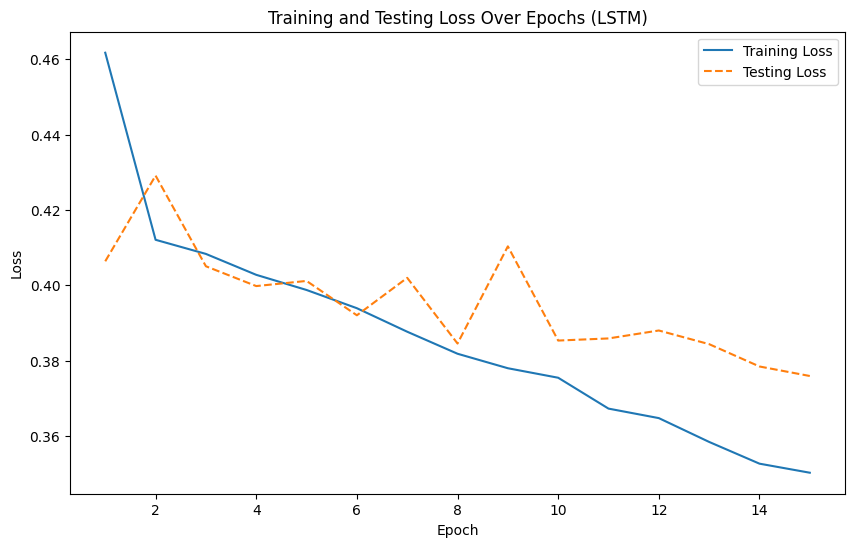

In [17]:
# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
plt.plot(range(1, len(test_losses) + 1), test_losses, label="Testing Loss", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Testing Loss Over Epochs (LSTM)")
plt.legend()
plt.show()

# Text Summarisation Task

In [18]:
data_processed = pl.read_ndjson('../data/news/processed_articles.json')

In [19]:
w2v_summarise_text = Word2Vec(data_processed['text'].to_list(), vector_size = 100, sg = 1, workers = 10, window = 32, epochs = 5)
w2v_summarise_headline = Word2Vec(data_processed['headline'].to_list(), vector_size = 100, sg = 1, workers = 10, window = 32, epochs = 5)

In [20]:
def txt_head_to_embedding(review, max_seq_len, embedding_dim, model):
    embeddings = [
        model.wv[word] if word in model.wv else np.zeros(embedding_dim)
        for word in review
    ]
    embeddings = embeddings[:max_seq_len]  # Truncate
    # Pad with zeros if shorter than max_seq_len
    if len(embeddings) < max_seq_len:
        embeddings += [np.zeros(embedding_dim)] * (max_seq_len - len(embeddings))
    return np.array(embeddings, dtype=np.float32)

In [21]:
# Model parameters
input_size = 100  # Word2Vec vector size
hidden_size = 128
output_size = 100  # Word2Vec vector size
max_seq_len = 32
epochs = 10
batch_size = 32
learning_rate = 0.001

In [22]:
data_embeded = data_processed.with_columns(
    pl.col("text").map_elements(lambda x: txt_head_to_embedding(x, 32, 100, w2v_summarise_text), return_dtype=list[list[float]]),
    pl.col("headline").map_elements(lambda x: txt_head_to_embedding(x, 32, 100, w2v_summarise_headline), return_dtype=list[list[float]])
)

In [23]:
train_data_x, test_data_x, train_data_y, test_data_y = train_test_split(data_embeded['text'], data_embeded['headline'],
                                         test_size=0.2, random_state=42)

In [27]:
class SummaryDataset(torch.utils.data.Dataset):
    def __init__(self, data_x, data_y):
        self.texts = torch.tensor(data_x, dtype=torch.float32)
        self.headlines = torch.tensor(data_y, dtype=torch.float32)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.headlines[idx]

In [28]:
train_dataset = SummaryDataset(train_data_x, train_data_y)
test_dataset = SummaryDataset(test_data_x, test_data_y)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [29]:
class TextSummarizerLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, max_seq_len):
        super(TextSummarizerLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.max_seq_len = max_seq_len

        # Replace RNN with LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.decoder = nn.Linear(hidden_size, output_size)
        self.output_projection = nn.Linear(output_size, output_size * max_seq_len)

    def forward(self, x):
        # x shape: [batch_size, seq_len, input_size]
        _, (hidden, _) = self.lstm(x)  # LSTM returns (hidden, cell)
        # hidden shape: [1, batch_size, hidden_size]

        hidden = self.layer_norm(hidden.squeeze(0))  # Use only the hidden state
        # hidden shape: [batch_size, hidden_size]

        decoded = self.decoder(hidden)
        # decoded shape: [batch_size, output_size]

        output = self.output_projection(decoded)
        # Reshape to match target shape
        output = output.view(-1, self.max_seq_len, output.size(-1) // self.max_seq_len)
        # output shape: [batch_size, max_seq_len, output_size]

        return output


In [30]:
model = TextSummarizerLSTM(input_size, hidden_size, output_size, max_seq_len)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [31]:
train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        inputs, targets = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for batch in test_loader:
            inputs, targets = batch
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

Epoch 1/15, Train Loss: 0.0097, Test Loss: 0.0060
Epoch 2/15, Train Loss: 0.0046, Test Loss: 0.0032
Epoch 3/15, Train Loss: 0.0023, Test Loss: 0.0015
Epoch 4/15, Train Loss: 0.0011, Test Loss: 0.0007
Epoch 5/15, Train Loss: 0.0006, Test Loss: 0.0004
Epoch 6/15, Train Loss: 0.0004, Test Loss: 0.0003
Epoch 7/15, Train Loss: 0.0003, Test Loss: 0.0002
Epoch 8/15, Train Loss: 0.0003, Test Loss: 0.0002
Epoch 9/15, Train Loss: 0.0002, Test Loss: 0.0002
Epoch 10/15, Train Loss: 0.0002, Test Loss: 0.0002
Epoch 11/15, Train Loss: 0.0001, Test Loss: 0.0002
Epoch 12/15, Train Loss: 0.0001, Test Loss: 0.0001
Epoch 13/15, Train Loss: 0.0001, Test Loss: 0.0001
Epoch 14/15, Train Loss: 0.0001, Test Loss: 0.0001
Epoch 15/15, Train Loss: 0.0001, Test Loss: 0.0001


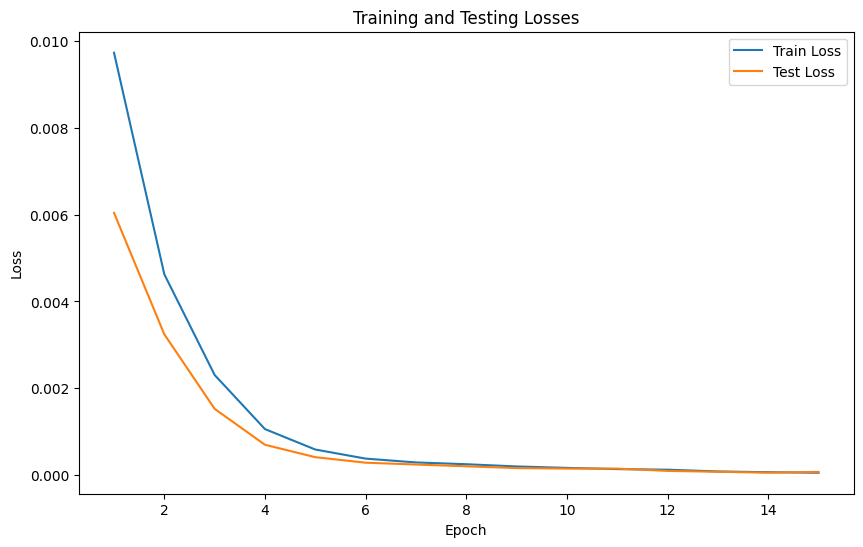

In [32]:
# Plot the training and testing losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS + 1), train_losses, label='Train Loss')
plt.plot(range(1, EPOCHS + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Losses')
plt.legend()
plt.show()